# Regular Auto-Encoder w/Categorical Data

We are going to continue the auto-encoder series by slightly tweaking the input and output. In the previous examples we encoded every input into one very long one-hot encoded vector. We used that vector as input and predicted it as output.

In this notebook we are going to be using `Categorical` data, use embeddings and then predict each embedding. This then makes our prediction problem a sort of multi-label and multi-class problem. Each embedding will be a label we predict, and each label has multiple potential classses (depending on the cardinality of the input.

## Requirements
Before running the experiment, make sure to import the `numpy`, `pandas` and `numba`, `torch`, `tqdm`, `matplotlib`, `scikit-learn`, `captum` packages in your virtual environment
```
> pip install numpy
> pip install pandas
> pip install numba
> pip install torch
> pip install tqdm
> pip install matplotlib
> pip install scikit-learn
> pip install captum
```
And that the notebook can find the `f3atur3s`, `eng1n3` and `m0d3l` packages.

In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import f3atur3s as ft
import eng1n3.pandas as en
import m0d3l.pytorch as mp
import m0d3l.plot as mplt

import m0d3l.captum as cp

from captum.attr import IntegratedGradients

from typing import Tuple

/home/toms/Jupyter/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Set a random seed for Numpy and Torch
Will make sure we always sample in the same way. Makes it easier to compare results. At some point it should been removed to test the model stability.

In [2]:
# Numpy
np.random.seed(42)
# Torch
torch.manual_seed(42)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [3]:
## Set up the devices, on from the data and one for modeling.
data_device  = torch.device('cpu')
model_device = torch.device('cuda') if torch.cuda.is_available() else data_device

## File Location
Change this to read from another location

In [4]:
file = '../../../../data/bs140513_032310.csv'

## Define Features
All features for this model are set up either as `FeatureBin` or `FeatureIndex` both of which will encode the data as an index/long value. And both of these feature classes can be used in an embedding layer.

When compared to the previous Auto-Encoder input, we see we know have 5 *index* values instead of 105 *binary* values

We also define the fraud-label but we will only be using it for the tesing phase. The fraud label is **not used during training**.

In [5]:
age      = ft.FeatureSource('age', ft.FEATURE_TYPE_CATEGORICAL)
gender   = ft.FeatureSource('gender', ft.FEATURE_TYPE_CATEGORICAL)
merchant = ft.FeatureSource('merchant', ft.FEATURE_TYPE_CATEGORICAL)
category = ft.FeatureSource('category', ft.FEATURE_TYPE_CATEGORICAL)
amount   = ft.FeatureSource('amount', ft.FEATURE_TYPE_FLOAT)
fraud    = ft.FeatureSource('fraud', ft.FEATURE_TYPE_INT_8)

amount_binned = ft.FeatureBin('amount_bin', ft.FEATURE_TYPE_INT_16, amount, 30)
age_i        = ft.FeatureIndex('age_index', ft.FEATURE_TYPE_INT_8, age)
gender_i     = ft.FeatureIndex('gender_index', ft.FEATURE_TYPE_INT_8, gender)
merchant_i   = ft.FeatureIndex('merchant_index', ft.FEATURE_TYPE_INT_16, merchant)
category_i   = ft.FeatureIndex('category_index', ft.FEATURE_TYPE_INT_16, category)
fraud_label  = ft.FeatureLabelBinary('fraud_label', ft.FEATURE_TYPE_INT_8, fraud)

# TensorDefinitions
td_i     = ft.TensorDefinition('index', [amount_binned, age_i, gender_i, merchant_i, category_i])
td_label = ft.TensorDefinition('label', [fraud_label])

with en.EnginePandas() as e:
    ti = e.np_from_csv((td_i, td_label), file, inference=False)

print(ti.shapes)
print(ti.dtype_names)

2023-05-10 17:03:01.347 eng1n3.common.engine           INFO     Start Engine...
2023-05-10 17:03:01.348 eng1n3.pandas.pandasengine     INFO     Pandas Version : 1.5.3
2023-05-10 17:03:01.349 eng1n3.pandas.pandasengine     INFO     Numpy Version : 1.23.5
2023-05-10 17:03:01.350 eng1n3.pandas.pandasengine     INFO     Building Panda for : All_r_1 from file ../../../../data/bs140513_032310.csv
2023-05-10 17:03:01.604 eng1n3.pandas.pandasengine     INFO     Reshaping DataFrame to: All_r_1
2023-05-10 17:03:01.608 eng1n3.pandas.pandasengine     INFO     Converting All_r_1 to 2 numpy arrays


((594643, 5), (594643, 1))
('int16', 'int8')


## Create Data-Sets and Loaders
Here we do something slightly differently than in the previous models. We **filter out the fraudulent** transactions for our training and validation test. The training and validation datasets will **only contain non-fraudulent** records. The test dataset will contain **both fraudulent and non-fraudulent** transactions.

In [6]:
train, val, test = ti.split_sequential(30000, 100000)

# Filter. Only keep non-fraud records with label 0. 
train = train.filter_label(0)
val   = val.filter_label(0)

batch_size = 128
# Creating DataSets
train_ds = mp.TensorInstanceNumpyDataSet(train)
val_ds   = mp.TensorInstanceNumpyDataSet(val)
test_ds  = mp.TensorInstanceNumpyDataSet(test)

# Creating an oversampler for the training set.
train_sampler = mp.TensorInstanceNumpyLabelSampler.over_sampler(train)

# Setting up the Dataloaders.
train_dl = train_ds.data_loader(data_device, batch_size, num_workers=2, sampler=train_sampler)
val_dl   = val_ds.data_loader(data_device, batch_size, num_workers=2)
test_dl  = test_ds.data_loader(data_device, batch_size, num_workers=2)

print(train.shapes)
print(val.shapes)
print(test.shapes)

((458847, 5), (458847, 1))
((29670, 5), (29670, 1))
((100000, 5), (100000, 1))


## Create AutoEncoder Model
The next cell creates the auto-encoder model, first we try a simple linear auto-encoder

In [7]:
class AutoEncoderModel(mp.AutoEncoder):
    def __init__(self, model_configuration: mp.ModelConfiguration):
        # Always call init, it is very important to correctly initialize the nn.Module
        super(AutoEncoderModel, self).__init__(model_configuration)
        self.heads   = self.create_heads()
        heads_size   = sum([h.output_size for h in self.heads])
        self.encoder = self.create_linear_encoder(heads_size, layer_sizes=(16, 3), dropout=0.1, bn_interval=0)
        self.decoder = self.create_linear_decoder(layer_sizes=(3, 16), dropout=0.1, bn_interval=0)

    def forward(self, x: Tuple[torch.Tensor, ...]) -> Tuple[torch.Tensor, ...]:
        # Forward through the head, there will only be one head, so no need to concat.
        o = self.heads[0](x[0])
        # The forward creates the latent representation by calling the encoder.
        latent = self.encoder(o)
        # Then feeds the latent representation into the decoder.
        o = self.decoder(latent)
        return (o,)
        
model = AutoEncoderModel(mp.ModelConfiguration.from_tensor_definitions(ti.target_tensor_def))
model

AutoEncoderModel(
  Number of parameters : 7317. Loss : MultiLabelNLLLoss,  mean
  (heads): ModuleList(
    (0): TensorDefinitionHead(
      Name=index, lc=Categorical
      (embedding): Embedding(
        (embeddings): ModuleList(
          (0): Embedding(30, 15)
          (1): Embedding(9, 5)
          (2): Embedding(5, 5)
          (3): Embedding(51, 25)
          (4): Embedding(16, 8)
        )
        (dropout): Dropout(p=0.1, inplace=False)
      )
    )
  )
  (encoder): LinearEncoder(
    (enc_lin): LinLayer(
      (layers): Sequential(
        (lin_layer_01): Linear(in_features=58, out_features=16, bias=True)
        (lin_act_01): ReLU()
        (lin_dropout_01): Dropout(p=0.1, inplace=False)
        (lin_layer_02): Linear(in_features=16, out_features=3, bias=True)
      )
    )
  )
  (decoder): LinearDecoder(
    (layers): Sequential(
      (linear_decoder): LinLayer(
        (layers): Sequential(
          (lin_layer_01): Linear(in_features=3, out_features=16, bias=True)
    

Visually this model would like more or less like below. (Some layers are omitted for simplicity)

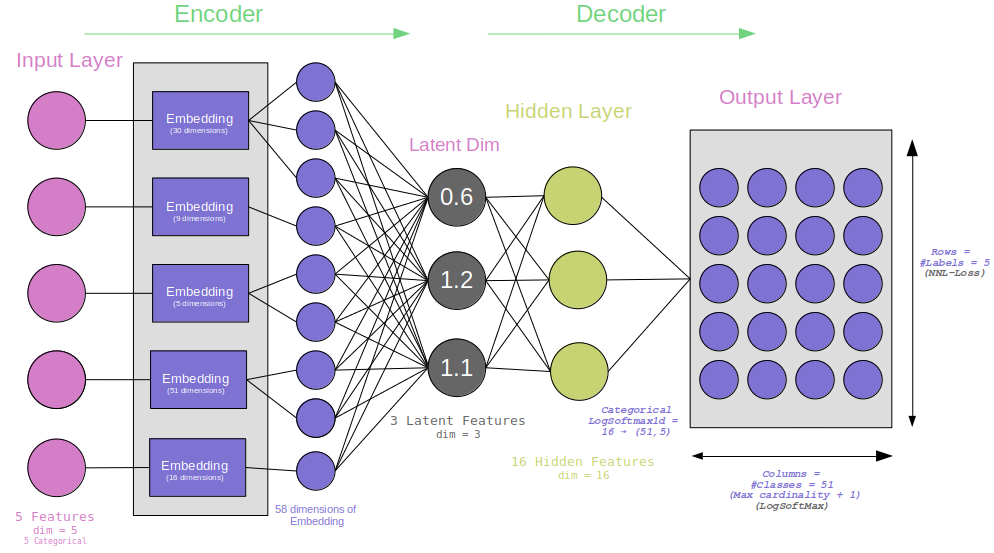

The crux of this model is in the last layer. This is a bit specific, it is going to make multiple label predictions in a in a CrossEntropy mode. (Much like how in vision applications, the content of an image is predicted). But here we are not going to predict a single object (label) but 5 in one go.

- It is going to receive a (B x 16) input from the hidden layer.
- Is is going to multiple that inpu by a (16 x 51 x 5) weight tensor. Resulting in a (B x 51 x 5) tensor.
- The (B x 51 x 5) goes through a LogSoftMax layer. Resulting in a (B x 51 x 5) containing the log probablilties.
- For instance 
    - Entry 0, 0, 0 is the log probabability for sample 0, the 0st class (bin 0) and label 0 (amount binned)
    - Entry 2, 2, 3 is the log probability for sample number 3, the second class and label 2 (gender)
- These can be run through a NLLLoss. The torch NLLLoss https://pytorch.org/docs/stable/generated/torch.nn.NLLLoss.html will assume that the second dimension is the class dimension. And the following is the k-dimension. (In our case we have 5 k's, each of our labels, as we had 5 input indexes)

## Find Learning Rate
For auto-encoders we will use a learning rate that is relatively close to the dropoff point, auto-encoders seem to train better with lower learning rates.

Finding LR in 200 steps: 100%|██████████| 200/200 [00:00<00:00, 250.79it/s]                                                    


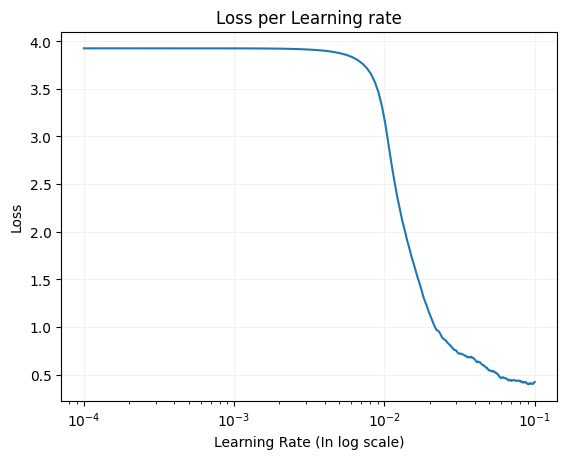

In [8]:
min_lr = 1e-4
max_lr = 1e-1
m_lr = AutoEncoderModel(mp.ModelConfiguration.from_tensor_definitions(ti.target_tensor_def))
o_lr = mp.AdamWOptimizer(m_lr, lr=min_lr)
t_lr = mp.Trainer(m_lr, model_device, train_dl, val_dl)
lrs  = t_lr.find_lr(o_lr, max_lr, 200)
mplt.TrainPlot.plot_lr(lrs);

## Train

In [9]:
EPOCHS = 5

# First create a trainer.
trainer = mp.Trainer(model, model_device, train_dl, val_dl)
# Then an optimizer
optimizer = mp.AdamWOptimizer(model, lr=5e-3)
# Set up a OneCycle Scheduler
scheduler = torch.optim.lr_scheduler.OneCycleLR(
            optimizer=optimizer.optimizer, 
            max_lr=optimizer.lr,
            steps_per_epoch=trainer.number_of_train_steps,
            epochs=EPOCHS
)

# Run the trainer for [EPOCH] epochs
history = trainer.train(EPOCHS, optimizer, scheduler)

Epoch 005/005: 100%|██████████| 3817/3817 [00:05<00:00, 737.21it/s, t_loss=0.0738, v_loss=0.0363]                              


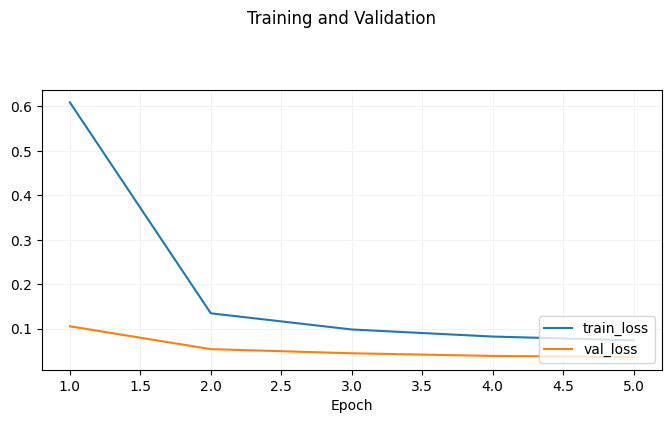

In [10]:
mplt.TrainPlot.plot_history(history, fig_size=(8,8));

## Testing the model
Our new 'embedding' Auto-Encoder has a fairly OK result, it does slightly better on the AUC than the regular auto-encoders. The value of our loss metric are much broader. This is because here we are using a Cross-Entropy loss on each embedding.

Calculating loss in 782 steps: 100%|████████| 782/782 [00:00<00:00, 1525.50it/s]


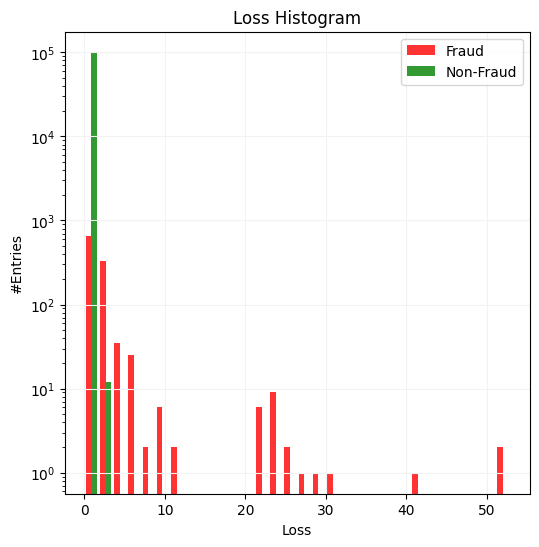

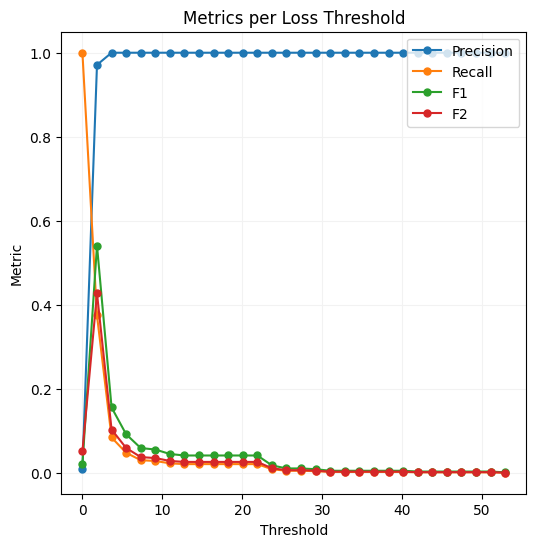

In [11]:
t = mp.Tester(model, model_device, test_dl)
results = t.test_results_loss()
mplt.TestPlot.plot_loss_binary(results, 30, fig_size=(6,6));
mplt.TestPlot.plot_loss_metrics(results, 30, fig_size=(6,6));

------------- Classification report -----------------
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00     98926
         1.0       0.87      0.59      0.70      1074

    accuracy                           0.99    100000
   macro avg       0.93      0.80      0.85    100000
weighted avg       0.99      0.99      0.99    100000


auc score : 0.9891
ap score  : 0.7151
-----------------------------------------------------


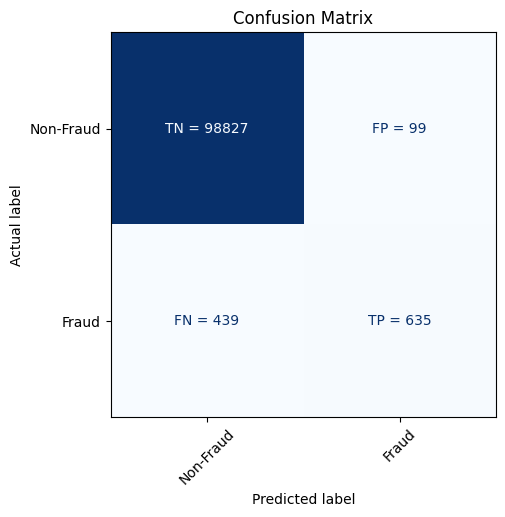

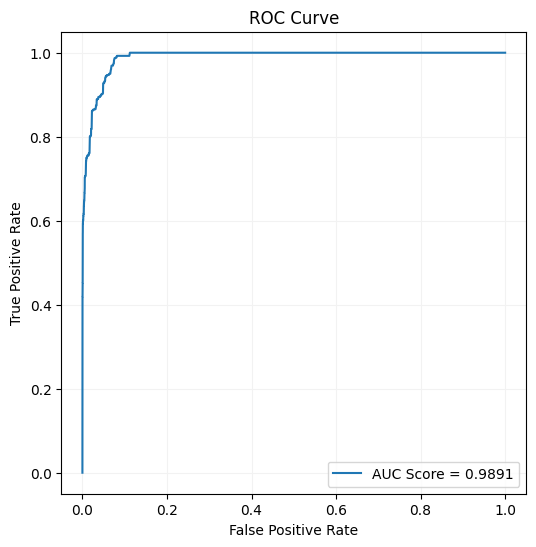

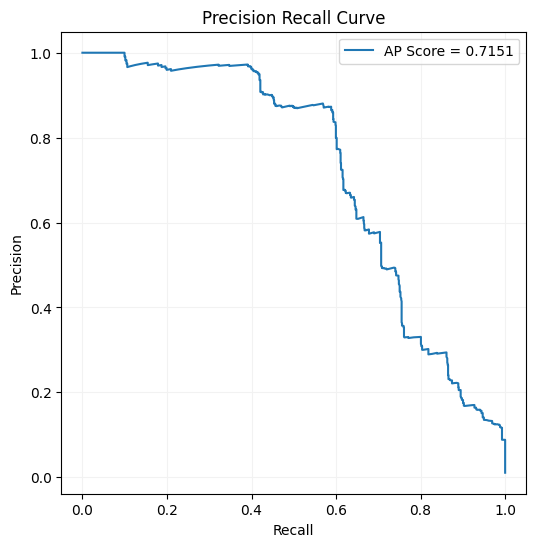

In [12]:
mplt.TestPlot.print_binary_classification_report(results, threshold=1.10)
mplt.TestPlot.plot_binary_confusion_matrix(results, fig_size=(5,5), threshold=1.10);
mplt.TestPlot.plot_roc_curve(results, fig_size=(6,6));
mplt.TestPlot.plot_precision_recall_curve(results, fig_size=(6,6))

## Visualizing the Embeddings. 

Other than the previous models, this one uses an embedding the head-layers, we can visualize them to see it they capture other sorts of 'aspects' as compared to the classifier models 

### Weight

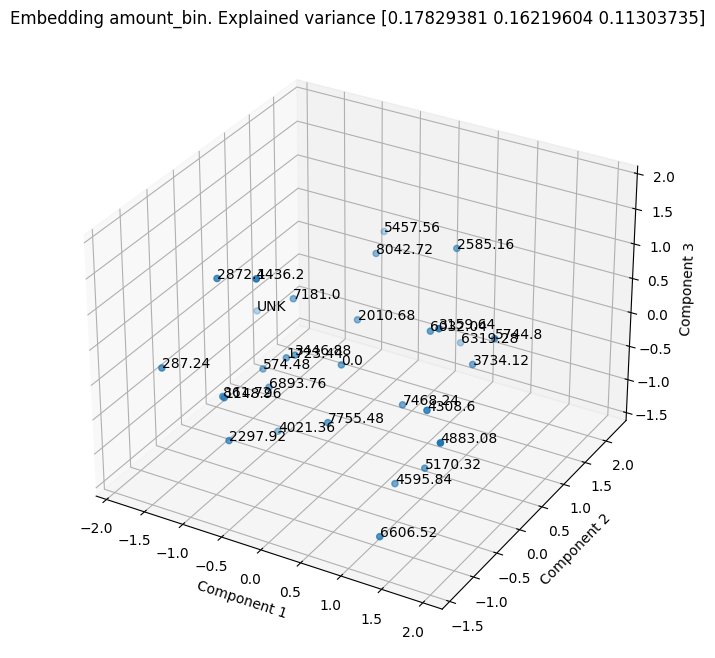

In [13]:
amount_weights = model.heads[0].embedding.embedding_weight(amount_binned).detach().cpu().numpy()
mplt.EmbeddingPlot.decompose_and_plot(amount_binned, amount_weights, dims=3, fig_size=(8,8))

### Age

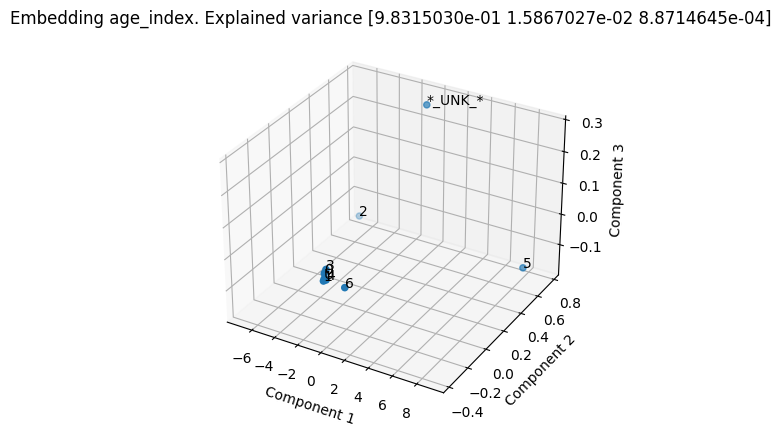

In [14]:
age_weights = model.heads[0].embedding.embedding_weight(age_i).detach().cpu().numpy()
mplt.EmbeddingPlot.decompose_and_plot(age_i, age_weights, dims=3, fig_size=(5,5))

### Gender

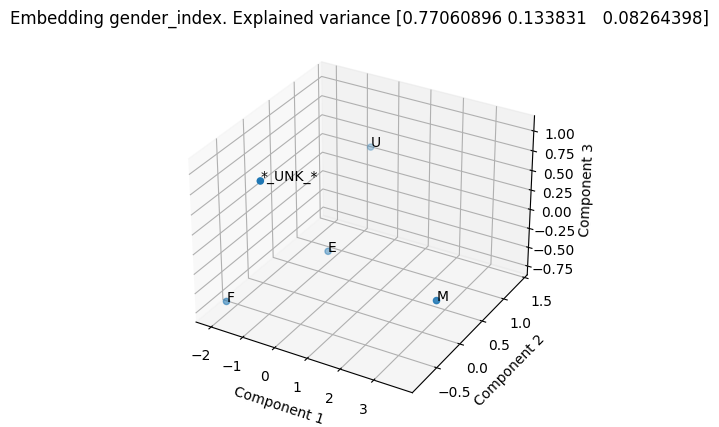

In [15]:
gender_weights = model.heads[0].embedding.embedding_weight(gender_i).detach().cpu().numpy()
mplt.EmbeddingPlot.decompose_and_plot(gender_i, gender_weights, dims=3, fig_size=(5,5))

### Merchant

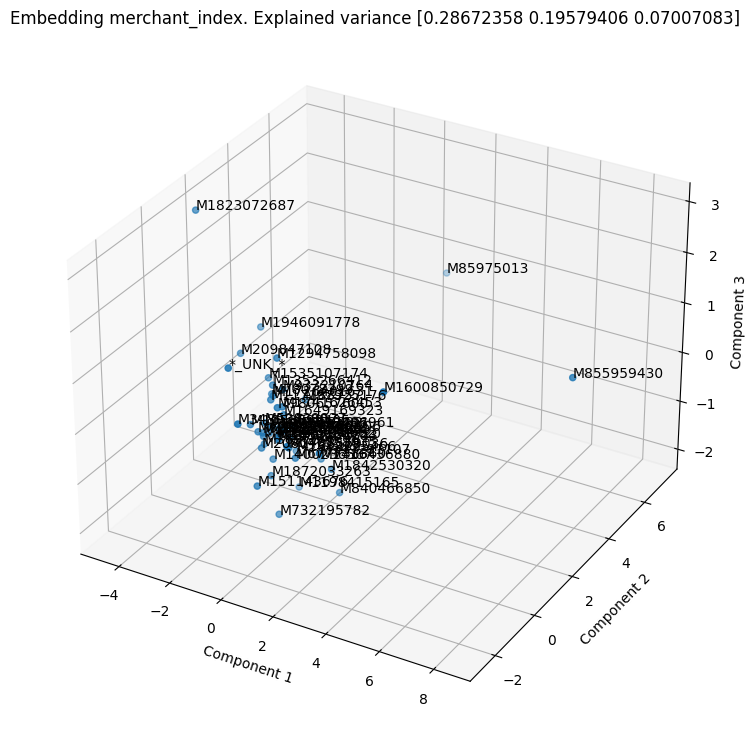

In [16]:
mer_weights = model.heads[0].embedding.embedding_weight(merchant_i).detach().cpu().numpy()
mplt.EmbeddingPlot.decompose_and_plot(merchant_i, mer_weights, dims=3, fig_size=(9,9))

### Category

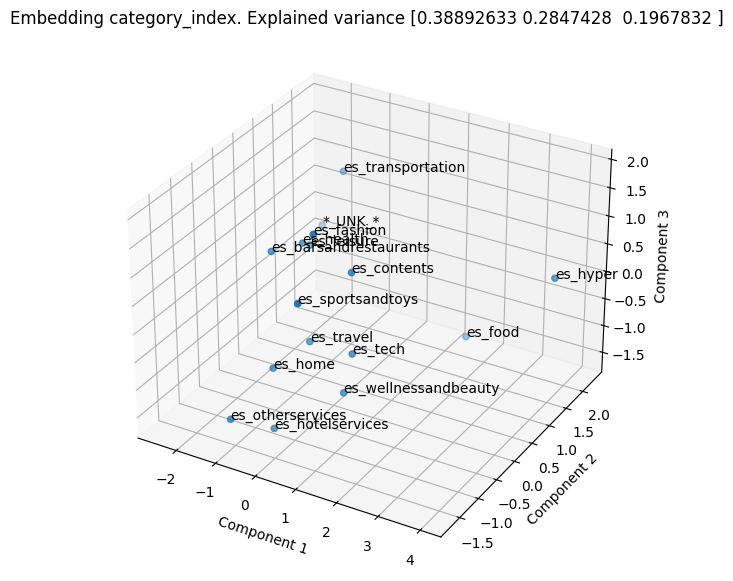

In [17]:
cat_weights = model.heads[0].embedding.embedding_weight(category_i).detach().cpu().numpy()
mplt.EmbeddingPlot.decompose_and_plot(category_i, cat_weights, dims=3, fig_size=(7,7))

## Visualizing the latent space.
We can have some fun trying to visualize what the latent space looks like. In order to do so, we will create a model that uses the `encoder` only, run some test data through and plot the output.

### Create model

In [18]:
class EncoderOnlyModel(mp.AutoEncoder):
    def __init__(self, model_configuration: mp.ModelConfiguration):
        # Always call init, it is very important to correctly initialize the nn.Module
        super(EncoderOnlyModel, self).__init__(model_configuration)
        self.heads   = self.create_heads()
        heads_size   = sum([h.output_size for h in self.heads])
        self.encoder = self.create_linear_encoder(heads_size, layer_sizes=(16, 3), dropout=0.1, bn_interval=0)

    def forward(self, x: Tuple[torch.Tensor, ...]) -> Tuple[torch.Tensor, ...]:
        # Forward through the head, there will only be one head, so no need to concat.
        o = self.heads[0](x[0])
        # The forward creates the latent representation by calling the encoder.
        latent = self.encoder(o)
        return (latent,)
    
        
enc_model = EncoderOnlyModel(mp.ModelConfiguration.from_tensor_definitions(ti.target_tensor_def))
enc_model

EncoderOnlyModel(
  Number of parameters : 2918. Loss : MultiLabelNLLLoss,  mean
  (heads): ModuleList(
    (0): TensorDefinitionHead(
      Name=index, lc=Categorical
      (embedding): Embedding(
        (embeddings): ModuleList(
          (0): Embedding(30, 15)
          (1): Embedding(9, 5)
          (2): Embedding(5, 5)
          (3): Embedding(51, 25)
          (4): Embedding(16, 8)
        )
        (dropout): Dropout(p=0.1, inplace=False)
      )
    )
  )
  (encoder): LinearEncoder(
    (enc_lin): LinLayer(
      (layers): Sequential(
        (lin_layer_01): Linear(in_features=58, out_features=16, bias=True)
        (lin_act_01): ReLU()
        (lin_dropout_01): Dropout(p=0.1, inplace=False)
        (lin_layer_02): Linear(in_features=16, out_features=3, bias=True)
      )
    )
  )
)

Copy across the weights

In [19]:
for name, param in model.named_parameters():
    if param.requires_grad:
         print(name)

heads.0.embedding.embeddings.0.weight
heads.0.embedding.embeddings.1.weight
heads.0.embedding.embeddings.2.weight
heads.0.embedding.embeddings.3.weight
heads.0.embedding.embeddings.4.weight
encoder.enc_lin.layers.lin_layer_01.weight
encoder.enc_lin.layers.lin_layer_01.bias
encoder.enc_lin.layers.lin_layer_02.weight
encoder.enc_lin.layers.lin_layer_02.bias
decoder.layers.linear_decoder.layers.lin_layer_01.weight
decoder.layers.linear_decoder.layers.lin_layer_01.bias
decoder.layers.tail.f_weight
decoder.layers.tail.f_bias


In [20]:
with torch.no_grad():
    for se, te in zip(model.heads[0].embedding.embeddings,enc_model.heads[0].embedding.embeddings):
        te.weight.copy_(se.weight)
    enc_model.encoder.enc_lin.layers.lin_layer_01.weight.copy_(model.encoder.enc_lin.layers.lin_layer_01.weight)
    enc_model.encoder.enc_lin.layers.lin_layer_01.bias.copy_(model.encoder.enc_lin.layers.lin_layer_01.bias)
    enc_model.encoder.enc_lin.layers.lin_layer_02.weight.copy_(model.encoder.enc_lin.layers.lin_layer_02.weight)
    enc_model.encoder.enc_lin.layers.lin_layer_02.bias.copy_(model.encoder.enc_lin.layers.lin_layer_02.bias)

### Sample and Test data

Now let's do some sampling, this piece of code samples all the fraud from our test data set and a random sample of non-fraud.

In [21]:
N_FRAUD_SAMPLE_SIZE = 5000

# Get the labels
y = torch.squeeze(test_ds[:][1])
# First Separate out the Fraud from the Non-Fraud
fraud=test_ds[np.where(y==1.0)]
n_fraud=test_ds[np.where(y==0.0)]
# Now Sample a number of Non-Fraud records
sample_index = torch.randperm(n_fraud[0].shape[0])[:N_FRAUD_SAMPLE_SIZE]
n_fraud = n_fraud[0][sample_index]

Run both samples through the model and convert to numpy

In [22]:
enc_model.eval()
with torch.no_grad():
    nf = enc_model((n_fraud,))[0].detach().numpy()
    f  = enc_model((fraud))[0].detach().numpy()

Now we can plot the data. Red are the Fraud points, green are non-fraud points. An observation we can make is that there seem to be 3 areas around which the dots sit. This is slightly different than in the 'One-Hot' auto-encoder. The fact that we have exactly 3 areas is interesting, one might wonder if that is related to our 3 dimensional latent space.

A slightly more subtle difference between this and the 'One-Hot' version is the size of the space. The plots here use a space at least 2~3 times the size of the 'One-Hot' version. That is somewhat of a concern. We know that models perfer input that is normal and roughly between 0 to 1 or -1 to 1. This is much broader, so we are giving our encoder input data we would never consider feeding as input to a model.



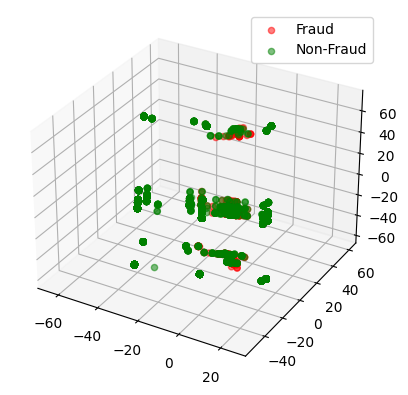

In [23]:
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
for color, label, a in [('red', 'Fraud', f), ('green', 'Non-Fraud', nf)]:
    ax.scatter3D(a[:,0], a[:,1], a[:,2], color=color, label=label, alpha=0.5)
ax.legend()
ax.grid(True)
plt.show();

Decompose into 2 dimension, using PCA and visualize.

In [24]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
# PCA the combined non-fraud and fraud.
p = pca.fit_transform(np.concatenate((nf,f)))
pca.explained_variance_ratio_

array([0.52746904, 0.3156485 ], dtype=float32)

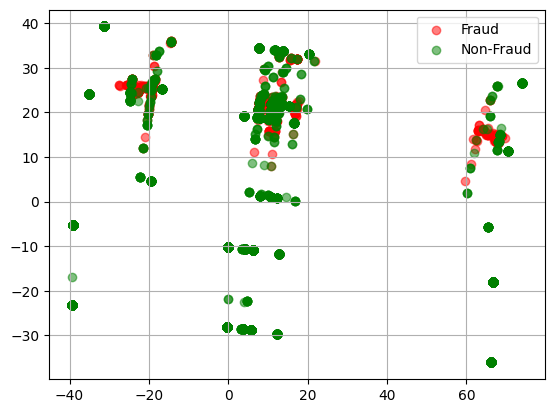

In [25]:
p_nf = p[:N_FRAUD_SAMPLE_SIZE]
p_f  = p[N_FRAUD_SAMPLE_SIZE:]
ax = plt.axes()
for color, label, a in [('red', 'Fraud', p_f), ('green', 'Non-Fraud', p_nf)]:
    ax.scatter(a[:,0], a[:,1], color=color, label=label, alpha=0.5)
plt.legend()
plt.grid(True)
plt.show()

## Conclusion
With this auto-encoder we saw that we can also use embeddings as input (as compared to the binary input of previous example) and that we can actually predict these embedding, using a multi-label cross entropy loss metric.